# ``py/Yggdrasil`` Demo

This is a notebook that is used as a live demonstration of py/Yggdrasil.
It shows what is possible with the application, but does not explain everything.
Consider it as a commercial.
It was done for the final presentation.


In [1]:
#
# L O A D I N G 
#

# Load pyYggdrasil and alias it as pyY
import pyYggdrasil as pyY

# The (random) distributions are implemented in a sub module 
# inside the pyYggdrasil module, and alias it as pyR
import pyYggdrasil.Random as pyR

# We also need NumPy
import numpy as np

# We also need to plot
# This import registers the 3D projection, but is otherwise unused.
from mpl_toolkits.mplot3d import Axes3D 

# Implement some more plot specific modules
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter

# Needed for the gauss kernel
from scipy import stats

# This is needed for timing the code
import time

#
# Settings

# This will make better plots (larger and higher quality)
# It must be executed twice, at least I have the impression that it is needed.
%config InlineBackend.figure_format = 'png'
mpl.rcParams['figure.dpi']= 250

In [2]:
# For that we also need an appropriate source of randomness.
geni = pyR.pRNG(42) 

# This is a large number, is used in various situations
aLargeNumber = 1000000

# For some reasons unkown to me this must be executed twice
%config InlineBackend.figure_format = 'png'
mpl.rcParams['figure.dpi']= 250

## Test Distribution

Throughout this demo we will use thew following three dimensional Gaussian distribution.
$$
\Sigma =
        \begin{pmatrix}
            0.35	& 0.25 	& 0.5 	\\
            0.25	& 0.4	& 0.6	\\
            0.5		& 0.6	& 1
        \end{pmatrix}
%
\qquad\qquad
%
\vec{\mu}_1 =
         \begin{pmatrix}
            -0.5    \\
             0      \\
             0
         \end{pmatrix}
%
\qquad\qquad
%
\vec{\mu}_2 =
         \begin{pmatrix}
             0.5    \\
             0      \\
             0
         \end{pmatrix}
%
\\
%
    \frac{1}{2} \, \mathcal{N}\!\left(\vec{\mu}_1,\, \Sigma\right) 
    + 
    \frac{1}{2} \, \mathcal{N}\!\left(\vec{\mu}_2,\, \Sigma\right) 
$$

In [3]:
#
# This are the parameters (as NumPy types)
Sigma = np.matrix([[0.35, 0.25, 0.5], [0.25, 0.4, 0.6], [0.5, 0.6, 1]])
Mu1   = np.array([-0.5, 0.0, 0.0])
Mu2   = np.array([ 0.5, 0.0, 0.0])

## How do we generate the samples?

For testing purposes Yggdrasil comes with a set of several random number generators.
But which one exists?
This is rather easy by using the doc string system.

Instead of using the generators provided by ``pyYggdrasil`` we could also have used generators implemented by NumPy, and fill up an NumPy matrix and load it into a container. 
But for the sake of demonstration we use generators provided by ``Yggdrasil``.

### The Help-System

In [4]:
#
# The generators are inside a submodule.
# We can get the information of that submodule by writting
help(pyY.Random)

Help on module pyYggdrasil.Random in pyYggdrasil:

NAME
    pyYggdrasil.Random - This submodule contains the distribution generators that are offered by yggdrasil. They operrate directly on the sample containers. Thus offer a more direct way of creating samples, than using the numpy distributions.

CLASSES
    pybind11_builtins.pybind11_object(builtins.object)
        MultiCondition
        RNDistribution
            Beta
            BiUniform
            Dirichlet
            Gamma
            Gauss
            MultiModal
            Outlier
            Uniform
        SingleCondition
        TreeSampler
        eDistiType
        pRNG
    
    class Beta(RNDistribution)
     |  This is the beta distribution. It is described by two parameters, Alpha and Beta. It can also be restricted to a certain part of the domain.
     |  
     |  Method resolution order:
     |      Beta
     |      RNDistribution
     |      pybind11_builtins.pybind11_object
     |      builtins.object
     |  
 

In [5]:
#
# This is rather crowded, we only want Gauss, for the beginning.
help(pyR.Gauss)

Help on class Gauss in module pyYggdrasil.Random:

class Gauss(RNDistribution)
 |  This class is a implementaion of the distribution interface. It implements a multi dimensional Gauss distribution. It uses Eigen matrices, which should be compatible to numpy matrices.
 |  
 |  Method resolution order:
 |      Gauss
 |      RNDistribution
 |      pybind11_builtins.pybind11_object
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  __init__(...)
 |      __init__(*args, **kwargs)
 |      Overloaded function.
 |      
 |      1. __init__(self: pyYggdrasil.Random.Gauss, mu: numpy.ndarray[float64[m, 1]], Sigma: numpy.ndarray[float64[m, n]], domain: pyYggdrasil.HyperCube) -> None
 |      
 |      This constructor constructs a Gaussian distribution, with has the median mu and the covariance matrix Sigma, which is something like the VARIANCE (this is different from many other interface, also from the C++ standard. There are no direct check if Sigma is symmertric, it is feeded to the 

### Actual Construction
Now we do the construction.
Since we have a multimodal distribution, we can not directly construct it.

We first have to construct the modes and then combine the modes.

#### Individual Modes
In a first step we construct the two Gaussian that consists forms the two modes of the multimodal distribution.

In [6]:

# Mode 1
gaussDist1 = pyR.Gauss(
    mu = Mu1,            # Mean of the distribution
    Sigma = Sigma,       # Variance of the distribution
    domain = pyY.HyperCube(len(Mu1), pyY.Interval(-10.0, 10.0))  # Where we sample
)

# Mode 2
gaussDist2 = pyR.Gauss(
    mu = Mu2,            # Mean of the distribution
    Sigma = Sigma,       # Variance of the distribution
    domain = pyY.HyperCube(len(Mu2), pyY.Interval(-10.0, 10.0))  # Where we sample
)

#### Multimodal
Now we will generate the multi modal distribution.
``Yggdrasil`` can construct such distributions out of the box.
(In Python only four modes are supported, complicated story why. In C++ any number of modes is supported.)

In [7]:
#
# Generate the multimodal distribution
mmodeDist = pyR.creatMultiModal(
    w1 = 0.5,            # Weight of the first mode
    m1 = gaussDist1,     # The first mode
    m2 = gaussDist2      # The second mode; its weight is implicitly given by $ 1 - w1 $
)

### Generating of the Samples

Now we generate the samples that we will use for fitting the tree.

Yggdrasil has three containers for storing samples.
There are that many, because different situations require different solutions.
They are described in the manual.
All containers implements a common interface standard, together with duck typing, this makes them interchangeable.

We will use the SampleCollection container.
This container is best if a tree should be constructed out of it (and the samples are not needed afterwards), since it is the internal representation of the samples in the tree.


In [8]:
#
# Now generate a large numbers of samples.
# The name encodes the return type, the suffix also tells that we want the pdf of the samples.
fitSamples = mmodeDist.generateSamplesCollection(
    g = geni,          # An explicit pRNG is needed
    N = aLargeNumber   # The number of samples we want
)

In [9]:
#
# We estimate mean and covariance of the generated samples
fitSamples_mean, fitSamples_covar = pyR.estMeanCovar(fitSamples)

print("The estimated mean is:   {}".format(fitSamples_mean))
print("The theoretical mean is: {}".format(mmodeDist.getMean()))

print()
print("The empirical covariance is:")
print(fitSamples_covar)

print("The theoretical covariance is:")
print(mmodeDist.getCoVar())


The estimated mean is:   [-0.00012161 -0.00025211 -0.00071741]
The theoretical mean is: [0. 0. 0.]

The empirical covariance is:
[[0.59849472 0.24901251 0.49819026]
 [0.24901251 0.39954903 0.59908904]
 [0.49819026 0.59908904 0.99831205]]
The theoretical covariance is:
[[0.6  0.25 0.5 ]
 [0.25 0.4  0.6 ]
 [0.5  0.6  1.  ]]


## Fitting a Tree
We will now generate a tree.
We have used the builder pattern as convenient way to specify the options that we want.
Python would provide named arguments, witch tackles part of the problem.

### Builder Object
Now we create a builder object.

In [10]:
builder = pyY.TreeBuilder(
    ).useLinearModel(         # Using a linear model
    ).setGOFLevel(0.001       # The significance level for the GOF-Test
    ).setIndepLevel(0.001     # The significance level for the independnece test
    ).useMedianSplitter(      # Use the median splitter
    )

### Actual Fitting
In order to fit a tree we need samples and a builder which stores the options of the tree.
We also need a domain for the tree.
If the domain is not given it will be estimated from the data.
We will use the domain that is specified the the test distribution.

We will load the sample collection directly inside the tree, this avoids a copy.
This is only possible when a ``SampleCollection`` is used.
The collection will be empty afterwards.

Constructing a tree will automatically call the fitting routine of the tree.

In [11]:
tree = pyY.DETree(
    samples = fitSamples,                  # The samples; will be empty afterwards.
    domain = mmodeDist.getSampleDomain(),  # The domain where the data lifes on
    load = True,                           # Move the samples into the tree; only possible when a collection is used
    builder = builder
)

In [12]:
#
# A samll inspection of the tree
stat = tree.getDepthMap()

print("Numbers of leafs: {}".format(stat.getLeafCount()))
print("Deepest depth: {}".format(stat.getDepthMax()))
print("Mean depth: {}".format(stat.getDepthMean()))
print("Std depth: {}".format(stat.getDepthStd()))

Numbers of leafs: 6846
Deepest depth: 17
Mean depth: 14.602687700847211
Std depth: 2.278560112982685


## Scaling Experiment
We now do a small scaling experiment.
Please keep in mind, that this experiment is not fully correct.
In reality one should test each size several time and compute an average and the standard deviation of the result.
But we have a tight schedule, we just do one tree per size.

In [13]:
#
# Experiment parameters
nExps      = 9    # The number of experiments
growthPar  = 0.4  # The growth parameter
startSize  = 2    # The start size
miseFactor = 9    # This is the MISE factor

#
# Result values
fitSizes  = np.zeros(nExps)    # This stores the sizes of the tree
treeMISEs = np.zeros(nExps)    # This is the recorded MISE


# start the timer
start = time.time()

#
# Test loop
for i in range(nExps):
    # Calculating the parameter of this iterations
    fitSize  = int(pow(10.0, startSize + growthPar * i))
    testSize = miseFactor * fitSize
    
    # Generate the samples that we need
    fitSamples_i = mmodeDist.generateSamplesCollection(g = geni, N = fitSize)
    testSamples_i, testSamplesPDF_i = mmodeDist.generateSamplesArrayPDF(g = geni, N = testSize)
    
    # Perform the fitting
    fitTree_i = pyY.DETree(
        samples = fitSamples_i,
        domain  = mmodeDist.getSampleDomain(),
        load    = True,
        builder = builder)
    
    # Evaluate the pdf of the test set
    testSamplesTreePDF_i = fitTree_i.evaluateSamplesAt(testSamples_i)
    
    # Evaluate the MISE 
    treeMISE = (((testSamplesTreePDF_i - testSamplesPDF_i)**2) / testSamplesPDF_i).sum() / len(testSamplesPDF_i)
    
    # Saving the results
    fitSizes[i]  = fitSize
    treeMISEs[i] = treeMISE
# end for(i): loop for the scalling

# stop the timer and print out the time
ende = time.time()
print("It took {} seconds.".format(ende - start))


It took 3.6348180770874023 seconds.


In [14]:
#
# Now plotting the result

plt.title("Developing of the MISE; as sample size increases")
plt.loglog(fitSizes, treeMISEs, '-ob')

# Prettyprinting
plt.xlabel("size")
plt.ylabel("MISE")

# output
plt.show()

## Conditioned Sampling
We will now prescribe the second and the third dimension of the test distribution to $0$.
We will then generate sample from this conditioned distribution.

By straight forward but tedious calculation we get
$$
\left.{\Sigma}\right\vert_{x_2 = 0, x_3 = 0} =
        \begin{pmatrix}
            0.2875		& 0 	& 0  	\\
            0			& 0		& 0		\\
            0    		& 0		& 0
        \end{pmatrix},
$$

as covariance.

The generated samples will still have full dimension and will include the conditioned values.

In [15]:
#
# This is the exact value of the covariance matrix
condCoVar_ex = np.matrix([[0.2875, 0, 0], [0, 0, 0], [0, 0, 0]])

# This is just for the sake of completnes
condSecondDim_val = 0.0
condThirdDim_val  = 0.0

### Encoding the Conditions
There are several ways of specifying the conditions that should be applied to the distribution.
We use a very simple one that builds on dict().
For more and cleaner ones, see the manual.


In [16]:
#
# We use a dict() for encoding the conditions.
# The KEY is the dimension we want to constraint on, and the associated VALUE is the condition
cond_dict = dict()
cond_dict[1] = 0.0    # Set the second component to zero; Zero based index
cond_dict[2] = 0.0

### Creating the Sampler
Now we will use the tree and the condition to create a conditioned sampler.
The constructor of the sampler will copy parts of the tree.
This means that the sampler is independent of the tree.
However the sampler can not (yet; this is a feature that maybe will get implemented in the future) calculate the probability of a “stand alone sample”.

In [17]:
#
# Generate the conditioned sampler
# The sampler copies everything it needes from tree,
# keeping the tree is not needed.
cond_sampler = pyR.TreeSampler(
    tree = tree,
    cMap = cond_dict      # The condition
)

# How many domains have joined the sampler
print("The sampler contains {} many domains out of {} that are inside the tree.".format(
                cond_sampler.nProxy(), 
                stat.getLeafCount())
)

#
# Get the condition object
conditions = cond_sampler.getConditions()

The sampler contains 31 many domains out of 6846 that are inside the tree.


### Small Test
We now test, if the generated samples obey the distribution that we expect.


In [18]:
#
# Generate conditioned samples from the tree
cond_samples = cond_sampler.generateSamplesArray(
                                            g = geni,              # Again a pRNG is needed
                                            N = 2 * aLargeNumber
)

In [19]:
#
# We estimate mean and covariance of the generated samples
cond_samples_mean, cond_samples_covar = pyR.estMeanCovar(cond_samples)

print("The estimated mean is:   {}".format(cond_samples_mean))

print()
print("The empirical covariance is:")
print(cond_samples_covar)

print()
print("The theoretical (true) covariance is:")
print(condCoVar_ex)

The estimated mean is:   [0.00904994 0.         0.        ]

The empirical covariance is:
[[0.2891625 0.        0.       ]
 [0.        0.        0.       ]
 [0.        0.        0.       ]]

The theoretical (true) covariance is:
[[0.2875 0.     0.    ]
 [0.     0.     0.    ]
 [0.     0.     0.    ]]


### Plotting the Result
We will compare the analytical pdf with the one given by the estimator and a histogram of randomly drawn samples.

The tree sampler can not be used to compute the pdf of samples.
For that we will use the tree itself and use it to compute the (unconditioned) pdfs.
We will then use the sampler to transform the unconditioned pdfs to conditioned ones.
We will also do the same for the analytical pdfs.


#### Preparation
Here we will make some preparation for the plotting.

In [20]:
# This are the bounds for the plotting
plotLowBound = -3.0    # not Symetric because of the legend
plotUppBound =  2.0

# This is the numbers of samples we use for plotting (~ grid points)
plotSamples = int((plotUppBound - plotLowBound) * 600)

# This is tzhe grid we use for plotting it is in 
# one dimenion and not in a container format.
condSampler_aSamples_fd = np.linspace(
            start = plotLowBound, 
            stop  = plotUppBound,
            num   = plotSamples
)

# Transform it in a container.
#  This is a restricted sample
condSampler_resSample = pyY.SampleArray(condSampler_aSamples_fd, pyY.eMatrixViewSample.Row)

# Now we will expand it, such that we get full 
#  samples that we can use.
condSampler_qSamples = conditions.expandSample(condSampler_resSample)

#### Analytical PDF
Here we compute the analytical values.

In [21]:
#
# Computing of the analytical (unconditioned) pdf values.
#  The samples that we use are compling to the condition.
condSampler_qSamples_exPDF = mmodeDist.pdf(condSampler_qSamples)

# We we transform the pdf such that it is conditioned.
#  For that we can use the tree sampler, that supports the value.
condSampler_qSamples_exPDF *= cond_sampler.getInvPxC()

#### Empirical PDF
Now we get the empirical pdf values.
For that we will use the tree and the transform the unconditioned pdfs, which are generated by the tree to conditioned one, by applying the constant.

This is needed because the sampler can not compute the pdf of a sample on its own.

In [22]:
#
# Computing of the empirical (unconditioned) pdf values.
#  The samples that we use are compling to the condition.
condSampler_qSamples_empPDF = tree.evaluateSamplesAt(condSampler_qSamples)

# We we transform the pdf such that it is conditioned.
#  For that we can use the tree sampler, that supports the value.
condSampler_qSamples_empPDF *= cond_sampler.getInvPxC()

#### Generate Histogram Data
Here we will generate the data for the histogram.
We will generate a number of samples and then restrict them.
(We could also use the `getDimensionalArray()` function, but for the sake of demonstration, we will restrict it, it is formal more correct. But I recommend doing the other thing.)

We will also check that the samples are inside the plot range.

In [23]:
# To get a good coverage, we need a lot of samples
plotSamples *= 20

# Generate random samples
condSampler_histSamplesFull = cond_sampler.generateSamplesCollection(g = geni, N = plotSamples)

# Restrict the samples, this will return a collection of dimension one.
condSampler_histSamplesRes_coll = conditions.restrictSample(condSampler_histSamplesFull)

# Convert the container into a real matrix
condSampler_histSamplesRes = condSampler_histSamplesRes_coll.getMatrix(pyY.eMatrixViewSample.Row)

# You could also do, it is directer, but the previous two lines are more formal.
#condSampler_histSamplesRes = condSampler_tSamples.condSampler_histSamplesFull(0)

# Get all the values that are inside the range
insidePlotRange = (condSampler_histSamplesRes >= plotLowBound) & (condSampler_histSamplesRes <= plotUppBound)

# Extract them
condSampler_histSamplesRes = condSampler_histSamplesRes[insidePlotRange]

#### Final Plotting

In [24]:
plt.title("Comparison of the tree and analytic pdf")
plt.xlabel("x")
plt.ylabel("pdf")

plt.hist(condSampler_histSamplesRes, density = True, 
         range = (plotLowBound, plotUppBound), bins = 200,
         label = "Histogram")
plt.plot(condSampler_aSamples_fd, condSampler_qSamples_exPDF, label="Analytic PDF")
plt.plot(condSampler_aSamples_fd, condSampler_qSamples_empPDF, label="Empiric PDF")

plt.legend(loc=2)
plt.show()

### Scaling Experiment
Here we do a small scaling experiment.
We will demonstrate how the number of samples, that are used to build the tree estimator, influences its ability to generate samples that obeys the source distribution.

We will generate a certain amount of samples and then fitting a tree with them.
Then we will generate a conditioned ``TreeSampler`` (same restriction as we have seen before).
We will then bootstrap a certain amount of samples and measure how well the distribution is.

As a measure for the accuracy we ill use the Frobenius norm of the error of the theoretical covariance and the one of the bootstrapped samples.

Again we do not compute a mean of the result to save time.

In [25]:
#
# Defining the parameters
nExps      = 10   # The number of experiments
growthPar  = 0.4  # The growth parameter
startSize  = 2    # The start size
bootFactor = 9    # How large should the bootstraped sample size be

# 
# Defining variables
fitSizes      = np.zeros(nExps)       # This is the number of samples we had for fitting
coVarErrorsB  = np.zeros(nExps)       # This is error we made; for the bootstraped samples
coVariancesB  = list()                # This is for storing all covarioances of the bootstraped samples

# This is the true covariance matrix
analytCoVar = condCoVar_ex

# Start the timer
start = time.time()

#
# Perform the experiment
for i in range(nExps):
    # Calculating the parameter of this iterations
    fitSize  = int(pow(10.0, startSize + growthPar * i))
    testSize = miseFactor * fitSize
       
    # Generate the samples for fitting
    fitSamples_i = mmodeDist.generateSamplesCollection(g = geni, N = fitSize)
    
    # Fit the tree
    fitTree_i = pyY.DETree(
        samples = fitSamples_i,
        domain  = mmodeDist.getSampleDomain(),
        load    = True,
        builder = builder)
    
    # Generate the sampler
    treeSampler_i = pyR.TreeSampler(fitTree_i, conditions)
    
    # Perform the resampling
    bootSamples_i = treeSampler_i.generateSamplesCollection(g = geni, N = testSize)
    
    # Calculate the covariance matrices of the bootstraped samples
    q, bootCoVar = pyR.estMeanCovar(bootSamples_i)
    
    # Compute the errors
    errI_boot_ana = bootCoVar   - analytCoVar
    
    #
    # Store the results
    
    fitSizes[i] = fitSize
    
    # Store the matrices
    coVariancesB.append(bootCoVar)
    
    # Store the errors
    coVarErrorsB[i]  = np.linalg.norm(errI_boot_ana, ord = 'fro')  
# end for(i): end of scalling test loop

# End the timer and output the time 
ende = time.time()
print("It took {} seconds.".format(ende - start))

It took 3.0833632946014404 seconds.


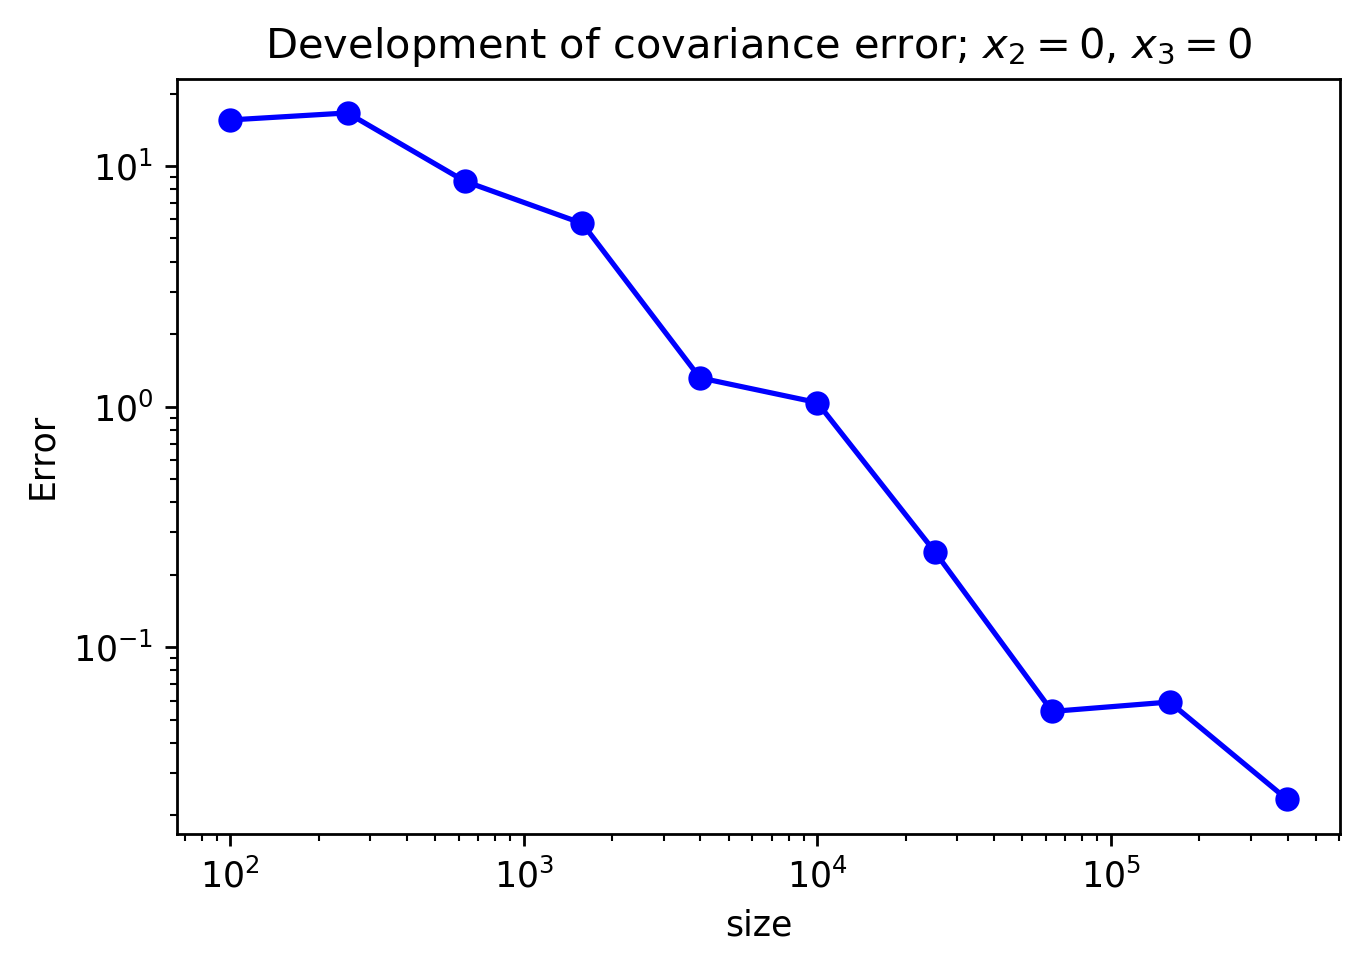

In [26]:
#
# Now plotting the result

plt.title("Development of covariance error; $x_2=0$, $x_3=0$")
plt.loglog(fitSizes, coVarErrorsB,  '-ob', label = 'Boot vs. A')

# Prettyprinting
plt.xlabel("size")
plt.ylabel("Error")

# output
plt.show()

## Unconditioned Sampling
We will now demonstrate the sampler if no condition was applied.

We will proceed as we have done it in the case were conditions where applied.



In [27]:
#
# We have to create a sampler.
unCond_sampler = pyR.TreeSampler(
    tree = tree
                    # Without any options; no restrictions are applied
)

### Small Test
We now test if the distribution of the bootstrapped samples are what we expect.
Since we have used the a finite sized set of samples to generate the ``TreeSampler`` we will also show that.

In [28]:
#
# Generate samples from the tree
unCond_samples, unCond_samples_estPDF = unCond_sampler.generateSamplesArrayPDF(
                                            g = geni,              # Again a pRNG is needed
                                            N = 2 * aLargeNumber
)

In [29]:
#
# We estimate mean and covariance of the generated samples
unCond_samples_mean, unCond_samples_covar = pyR.estMeanCovar(unCond_samples)

print("The estimated mean is:   {}".format(unCond_samples_mean))
print("The mean of the source is: {}".format(fitSamples_mean))
print("The theoretical mean is: {}".format(mmodeDist.getMean()))

print()
print("The empirical covariance (bootstrapped):")
print(unCond_samples_covar)

print("The covariance of the source is:")
print(fitSamples_covar)

print()
print("The theoretical (true) covariance is:")
print(mmodeDist.getCoVar())

The estimated mean is:   [ 6.74756421e-04  2.28981517e-05 -2.20126958e-04]
The mean of the source is: [-0.00012161 -0.00025211 -0.00071741]
The theoretical mean is: [0. 0. 0.]

The empirical covariance (bootstrapped):
[[0.65943045 0.25055975 0.50603378]
 [0.25055975 0.43157637 0.60812326]
 [0.50603378 0.60812326 1.04659148]]
The covariance of the source is:
[[0.59849472 0.24901251 0.49819026]
 [0.24901251 0.39954903 0.59908904]
 [0.49819026 0.59908904 0.99831205]]

The theoretical (true) covariance is:
[[0.6  0.25 0.5 ]
 [0.25 0.4  0.6 ]
 [0.5  0.6  1.  ]]


### Scaling Experiment
Again we perform a scaling experiment.
We will study how the accuracy of the samples generated by the ``TreeSampler`` depends on the number of samples that we used for fitting the tree.

As measure for accuracy, we use the Frobenius norm of the difference of the covariance matrix of the bootstrapped samples and the theoretical distribution.
We will also show how well the sample set, that was used for fitting captured the covariance of the theoretical distribution.

Again we perform only one run per size, this is done to save time for the presentation.

In [30]:
#
# Defining the parameters
nExps      = 10   # The number of experiments
growthPar  = 0.4  # The growth parameter
startSize  = 2    # The start size
bootFactor = 9    # How large should the bootstraped sample size be

# 
# Defining variables
fitSizes      = np.zeros(nExps)       # This is the number of samples we had for fitting
coVarErrorsB  = np.zeros(nExps)       # This is error we made; for the bootstraped samples
coVariancesB  = list()                # This is for storing all covarioances of the bootstraped samples
coVarErrorsS  = np.zeros(nExps)       # This is the error between the fitting samples and the bootstrapped samples
coVariancesS  = list()                # This is for storing all covaroiances of the fitting samples
coVarErrorsBS = np.zeros(nExps)       # This is the error between the bootstraped covar and the one of the sample

# This is the true covariance matrix
analytCoVar = mmodeDist.getCoVar()

# Start the timer
start = time.time()

#
# Perform the experiment
for i in range(nExps):
    # Calculating the parameter of this iterations
    fitSize  = int(pow(10.0, startSize + growthPar * i))
    testSize = miseFactor * fitSize
       
    # Generate the samples for fitting
    fitSamples_i = mmodeDist.generateSamplesCollection(g = geni, N = fitSize)
    
    # Calculate the covariance of the samples that are used for fitting
    q, fitCoVar  = pyR.estMeanCovar(fitSamples_i)
    
    # Fit the tree
    fitTree_i = pyY.DETree(
        samples = fitSamples_i,
        domain  = mmodeDist.getSampleDomain(),
        load    = True,
        builder = builder)
    
    # Generate the sampler
    treeSampler_i = pyR.TreeSampler(fitTree_i)
    
    # Perform the resampling
    bootSamples_i = treeSampler_i.generateSamplesCollection(g = geni, N = testSize)
    
    # Calculate the covariance matrices of the bootstraped samples
    q, bootCoVar = pyR.estMeanCovar(bootSamples_i)
    
    # Compute the errors
    errI_boot_fit = bootCoVar   - fitCoVar
    errI_boot_ana = bootCoVar   - analytCoVar
    errI_ana_fit  = analytCoVar - fitCoVar
    
    #
    # Store the results
    
    fitSizes[i] = fitSize
    
    # Store the matrices
    coVariancesB.append(bootCoVar)
    coVariancesS.append(fitCoVar)
    
    # Store the errors
    coVarErrorsB[i]  = np.linalg.norm(errI_boot_ana, ord = 'fro')
    coVarErrorsS[i]  = np.linalg.norm(errI_ana_fit,  ord = 'fro')
    coVarErrorsBS[i] = np.linalg.norm(errI_boot_fit, ord = 'fro')    
# end for(i): end of scalling test loop

# End the timer and output the time 
ende = time.time()
print("It took {} seconds.".format(ende - start))

It took 3.612394094467163 seconds.


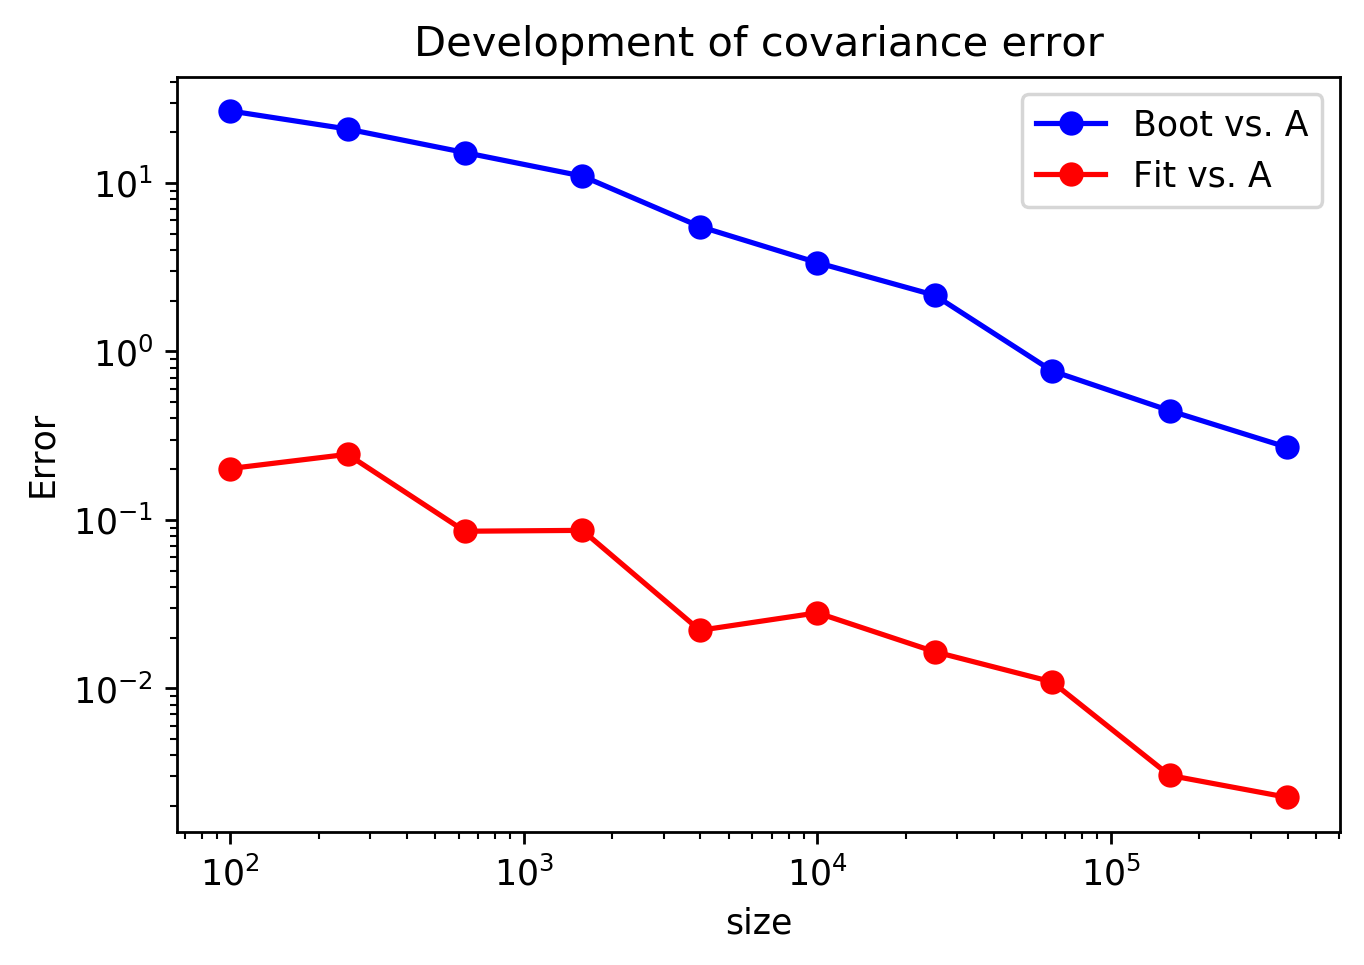

In [31]:
#
# Now plotting the result

plt.title("Development of covariance error")
plt.loglog(fitSizes, coVarErrorsB,  '-ob', label = 'Boot vs. A')
plt.loglog(fitSizes, coVarErrorsS,  '-or', label = 'Fit vs. A')

# Prettyprinting
plt.xlabel("size")
plt.ylabel("Error")
plt.legend()

# output
plt.show()